# Dev eFEL metric

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import efel

In [3]:
from brian2 import *
prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!


## Run model with 2 different sets of parameters

In [4]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [74]:
# Generate a step-current input and an "experimental" voltage trace
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*20*nA

params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [75]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [76]:
I = TimedArray(input_current, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(25*ms)

voltage1 = mon.v[0]/mV

In [77]:
start_scope()

### Generate Second Trace

In [78]:
I = TimedArray(input_current, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states({'gl': float(5e-5*siemens*cm**-2 * area),
              'g_na': float(110*msiemens*cm**-2 * area),
              'g_kd': float(40*msiemens*cm**-2 * area)}, units=False)
mon = StateMonitor(G, 'v', record=0)
run(25*ms)

voltage2 = mon.v[0]/mV

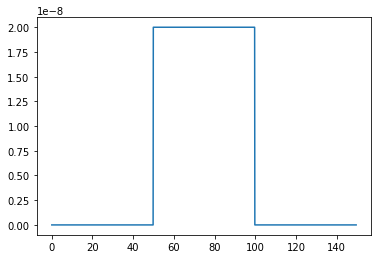

In [79]:
plot(np.arange(0, len(input_current)/10, 0.1), input_current)


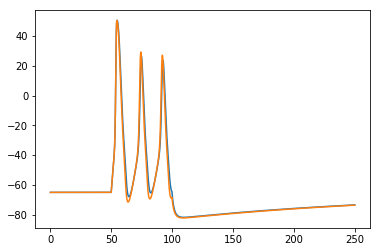

In [80]:
plot(np.arange(0, len(voltage1)/10, 0.1), voltage1)
plot(np.arange(0, len(voltage1)/10, 0.1), voltage2)

## Calculate Features and Errors

In [81]:
def calculate_features(traces, inp_times, feat_list):
    traces_list = []
    
    for i, trace in enumerate(traces):
        time = np.arange(0, len(trace)/10, 0.1)
        temp_trace = {}
        temp_trace['T'] = time
        temp_trace['V'] = trace
        temp_trace['stim_start'] = [inp_times[i][0]]
        temp_trace['stim_end'] = [inp_times[i][1]]
        traces_list.append(temp_trace)

    results = efel.getFeatureValues(traces_list, feat_list)

    return results

In [98]:
def feat_to_err(d1, d2):
    d3 = {key: d1[key] - d2.get(key, 0) for key in d1.keys()}   
    err = 0

    for k, v in d3.items():
        err += np.abs(sum(v))
        
    return err

In [83]:
fl = ['AP_amplitude', 'peak_time', 'peak_voltage', 'AP_begin_time', 'AP_begin_width', 
                                                 'AP_begin_voltage', 'mean_frequency']


inp_times = [[50,100]]

In [99]:
res1 = calculate_features([voltage1], inp_times, fl)
res2 = calculate_features([voltage2], inp_times, fl)

In [100]:
err = feat_to_err(res1[0], res2[0])
err

21.806871989371373